In [ ]:
import os
import sys
import torch
import glob
import pandas as pd
import numpy as np
import nilearn.connectome
import matplotlib.pyplot as plt
from nilearn.input_data import NiftiLabelsMasker, NiftiMapsMasker
from csv import writer
from load_confounds import Params9

sys.path.append(os.path.join(".."))
import time_windows_dataset
import graph_construction
import gcn_model

# print("torch v{}".format(torch.__version__))
# print("nilearn v{}".format(nilearn.__version__))
# print("simexp_gcn v{}".format(simexp_gcn.__version__))

In [2]:
# clf = RidgeCV(alphas=[100, 200, 300, 400, 600,  800, 900, 1000, 1200]) 

# Initial parameters

In [ ]:
TR = 1.49
random_seed = 0

subject = 'sub-01'
region_approach = 'MIST'
resolution = 444
window_length = 1
modality = 'all_mod' #'motor'
HRFlag_processes = '3volumes'

# Fetch data

In [ ]:
# paths
data_dir = os.path.join('..', '..', '..', 'data')

concat_data_dir = os.path.join(data_dir, 'concat_data', region_approach, str(resolution), subject)
processed_bold_files = sorted(glob.glob(concat_data_dir + '/*.npy'))

conn_dir = os.path.join(data_dir, 'connectomes')
conn_files = sorted(glob.glob(conn_dir + '/conn_30mins_friends_{}_{}{}.npy'.format(subject,
                                                                                    region_approach,
                                                                                    resolution)))
split_dir = os.path.join(data_dir, 'split_win_data')
out_csv = os.path.join(split_dir, 'labels.csv')
out_file = os.path.join(split_dir, '{}_{:04d}.npy')

result_dir = os.path.join('../results')
result_csv = os.path.join(result_dir, 'result_df.csv')
model_path = os.path.join('../models', 'gcn_test.pt')

In [5]:
if not os.path.exists(split_dir):
    os.makedirs(split_dir)
if not os.path.exists(conn_dir):
    os.makedirs(conn_dir)    
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
if not os.path.exists(result_csv):
    result_df = pd.DataFrame(columns=['subject','modality','window_length','region_approach',
                                      'average_loss','average_accuracy', 'time_window'])
    result_df.to_csv(result_csv, index=False)
    
# remove previous content
if os.path.exists(split_dir):
    files = glob.glob(os.path.join(split_dir, "*"))
    for f in files:
        os.remove(f)

In [6]:
path = '/home/SRastegarnia/hcptrt_decoding_Shima/data/concat_data/'\
       '{}/{}/{}'.format(region_approach, resolution, subject)

test_path_body0b = os.path.join(path, '{}_body0b_3volumes_concat_fMRI.npy'.format(subject))
test_path_body2b = os.path.join(path, '{}_body2b_3volumes_concat_fMRI.npy'.format(subject))
test_path_face0b = os.path.join(path, '{}_face0b_3volumes_concat_fMRI.npy'.format(subject))
test_path_face2b = os.path.join(path, '{}_face2b_3volumes_concat_fMRI.npy'.format(subject))
test_path_fear = os.path.join(path, '{}_fear_3volumes_concat_fMRI.npy'.format(subject))
test_path_footL = os.path.join(path, '{}_footL_3volumes_concat_fMRI.npy'.format(subject))
test_path_footR = os.path.join(path, '{}_footR_3volumes_concat_fMRI.npy'.format(subject))
test_path_handL = os.path.join(path, '{}_handL_3volumes_concat_fMRI.npy'.format(subject))
test_path_handR = os.path.join(path, '{}_handR_3volumes_concat_fMRI.npy'.format(subject))
test_path_match = os.path.join(path, '{}_match_3volumes_concat_fMRI.npy'.format(subject))
test_path_math = os.path.join(path, '{}_math_3volumes_concat_fMRI.npy'.format(subject))
test_path_mental = os.path.join(path, '{}_mental_3volumes_concat_fMRI.npy'.format(subject))
test_path_place0b = os.path.join(path, '{}_place0b_3volumes_concat_fMRI.npy'.format(subject))
test_path_place2b = os.path.join(path, '{}_place2b_3volumes_concat_fMRI.npy'.format(subject))
test_path_random = os.path.join(path, '{}_random_3volumes_concat_fMRI.npy'.format(subject))
test_path_relational = os.path.join(path, '{}_relational_3volumes_concat_fMRI.npy'.format(subject))
test_path_shape = os.path.join(path, '{}_shape_3volumes_concat_fMRI.npy'.format(subject))
test_path_story = os.path.join(path, '{}_story_3volumes_concat_fMRI.npy'.format(subject))
test_path_tongue = os.path.join(path, '{}_tongue_3volumes_concat_fMRI.npy'.format(subject))
test_path_tool0b = os.path.join(path, '{}_tool0b_3volumes_concat_fMRI.npy'.format(subject))
test_path_tool0b = os.path.join(path, '{}_tool0b_3volumes_concat_fMRI.npy'.format(subject))

a = np.load(test_path_body0b)
b = np.load(test_path_body2b)
c = np.load(test_path_face0b)
d = np.load(test_path_face2b)
e = np.load(test_path_fear)

print('body0b', len(a))
print('body2b', len(b))
print('face0b', len(c))
print('face2b', len(d))
print('fear', len(e))

body0b 306
body2b 248
face0b 304
face2b 296
fear 293


# Generating connectomes

In [7]:
# # دیگه استفاده نمیشه. برای یک اپیزود فرندز بود
# # Generates connectome from friends for GCN

# bold_suffix = '_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
# path_cneuromod = '/data/neuromod/projects/ml_models_tutorial/data/friends/raw_data'
# file_epi = os.path.join(path_cneuromod, 
#                         'sub-01_ses-003_task-s01e05a_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')

# conf = Params9()
# masker = NiftiLabelsMasker(labels_img = '../MIST_444.nii.gz', standardize=True, 
#                            smoothing_fwhm = 5, verbose=5)
# sample_ts = masker.fit_transform(file_epi, confounds=conf.load(file_epi)) 
# print(sample_ts.shape)

# # Estimating connectomes
# corr_measure = nilearn.connectome.ConnectivityMeasure(kind="correlation")
# conn = corr_measure.fit_transform([sample_ts])[0]
# np.save(os.path.join(conn_dir, 'conn_friends_{}_{}{}.npy'.format(subject, region_approach, 
#                                                                         resolution)), conn)

In [8]:
# # فقط یک بار نیاز است که اجرا شود و فایل ذخیره شده
# # Generates connectome from 30 mins of friens for GCN

# bold_suffix = '_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
# path_cneuromod = '/data/neuromod/projects/ml_models_tutorial/data/friends/raw_data/'
# files_epi = sorted(glob.glob(path_cneuromod + '{}_*_space-MNI152NLin2009cAsym'\
#                              '_desc-preproc_bold.nii.gz'.format(subject)))

# conf = Params9()
# masker = NiftiLabelsMasker(labels_img = '../MIST_444.nii.gz', standardize=True, 
#                            smoothing_fwhm = 5, verbose=5)

# connectom_idx = []
# for file_epi in files_epi:
#     sample_ts = masker.fit_transform(file_epi, confounds=conf.load(file_epi)) 
#     corr_measure = nilearn.connectome.ConnectivityMeasure(kind="correlation")
#     conn = corr_measure.fit_transform([sample_ts])[0]
#     connectom_idx.append(conn)

# np.save(os.path.join(conn_dir, 'conn_30mins_friends_{}_{}{}.npy'.format(subject, region_approach, 
#                                                                             resolution)), 
#         np.average(connectom_idx, axis=0))

# # conn_file = os.path.join(conn_dir, 'conn_friends_{}_{}{}.npy'.format(subject, region_approach, resolution))
# # print(conn_file)
# # a = np.load(conn_file)
# # print(np.shape(a))

# Split timeseries & generate label file

In [9]:
dic_labels = {'body0b':0,'body2b':1,'face0b':2,'face2b':3,'fear':4,'footL':5,'footR':6,
              'handL':7,'handR':8,'match':9,'math':10,'mental':11,'place0b':12,'place2b':13, 
              'random':14,'relational':15,'shape':16,'story':17,'tongue':18,'tool0b':19,'tool2b':20}


label_df = pd.DataFrame(columns=['label', 'filename'])
# print(len(processed_bold_files))

for proc_bold in processed_bold_files:
    
    ts_data = np.load(proc_bold)
#     print(ts_data)

    ts_duration = len(ts_data)
#     print(ts_duration)

    ts_filename = os.path.basename(proc_bold)
    ts_filename = "".join(ts_filename.split(".")[:-1])
    print(ts_filename)
    
    ts_label = ts_filename.split(subject+'_', 1)[1].split('_'+HRFlag_processes, 1)[0]
    print('ts_label:', ts_label)
    
    valid_label = dic_labels[ts_label]
    
    # Split the timeseries
    rem = ts_duration % window_length
    n_splits = int(np.floor(ts_duration / window_length))
    print('n_splits:', n_splits)
    ts_data = ts_data[:(ts_duration-rem), :]
    print('ts_data shape after removing rem:', np.shape(ts_data), '\n')    
    
    for j, split_ts in enumerate(np.split(ts_data, n_splits)):
        ts_output_file_name = out_file.format(ts_filename, j)
        print('ts_output_file_name:', ts_output_file_name)        
#         print('shape split_ts:', np.shape(split_ts))
#         print('split_ts:', split_ts)

        split_ts = np.swapaxes(split_ts, 0, 1)
        np.save(ts_output_file_name, split_ts)
        curr_label = {'label': valid_label, 'filename': os.path.basename(ts_output_file_name)}
        label_df = label_df.append(curr_label, ignore_index=True)
    print('------------------------------------------------------------------------------------------------')
    
label_df.to_csv(out_csv, index=False)        

sub-01_body0b_3volumes_concat_fMRI
ts_label: body0b
n_splits: 306
ts_data shape after removing rem: (306, 444) 

ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0000.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0001.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0002.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0003.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0004.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0005.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0006.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0007.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0008.npy
ts_output_file_name: ../../../data/split_

ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0090.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0091.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0092.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0093.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0094.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0095.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0096.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0097.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0098.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0099.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_bod

ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0183.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0184.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0185.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0186.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0187.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0188.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0189.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0190.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0191.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0192.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_bod

ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0280.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0281.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0282.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0283.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0284.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0285.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0286.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0287.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0288.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0289.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_bod

ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0061.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0062.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0063.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0064.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0065.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0066.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0067.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0068.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0069.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0070.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_bod

ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0154.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0155.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0156.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0157.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0158.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0159.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0160.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0161.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0162.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0163.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_bod

ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0001.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0002.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0003.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0004.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0005.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0006.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0007.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0008.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0009.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0010.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fac

ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0097.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0098.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0099.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0100.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0101.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0102.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0103.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0104.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0105.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0106.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fac

ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0185.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0186.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0187.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0188.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0189.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0190.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0191.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0192.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0193.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0194.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fac

ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0282.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0283.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0284.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0285.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0286.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0287.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0288.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0289.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0290.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0291.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fac

ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0078.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0079.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0080.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0081.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0082.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0083.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0084.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0085.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0086.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0087.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fac

ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0181.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0182.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0183.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0184.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0185.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0186.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0187.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0188.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0189.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0190.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fac

ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0277.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0278.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0279.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0280.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0281.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0282.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0283.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0284.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0285.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0286.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fac

ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0076.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0077.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0078.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0079.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0080.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0081.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0082.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0083.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0084.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0085.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0176.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0177.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0178.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0179.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0180.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0181.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0182.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0183.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0184.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0185.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0269.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0270.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0271.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0272.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0273.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0274.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0275.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0276.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0277.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0278.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0067.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0068.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0069.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0070.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0071.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0072.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0073.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0074.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0075.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0076.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0003.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0004.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0005.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0006.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0007.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0008.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0009.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0010.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0011.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0012.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0097.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0098.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0099.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0100.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0101.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0102.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0103.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0104.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0105.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0106.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0035.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0036.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0037.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0038.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0039.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0040.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0041.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0042.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0043.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0044.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0131.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0132.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0133.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0134.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0135.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0136.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0137.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0138.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0139.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0140.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0086.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0087.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0088.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0089.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0090.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0091.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0092.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0093.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0094.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0095.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0022.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0023.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0024.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0025.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0026.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0027.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0028.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0029.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0030.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0031.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0122.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0123.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0124.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0125.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0126.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0127.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0128.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0129.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0130.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0131.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0218.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0219.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0220.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0221.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0222.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0223.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0224.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0225.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0226.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0227.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0311.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0312.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0313.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0314.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0315.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0316.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0317.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0318.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0319.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0320.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0413.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0414.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0415.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0416.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0417.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0418.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0419.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0420.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0421.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0422.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0514.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0515.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0516.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0517.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0518.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0519.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0520.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0521.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0522.npy
------------------------------------------------------------------------------------------------
sub-01_math_3volumes_concat_fMRI
ts_label: math
n_splits: 1028
ts_

ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0081.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0082.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0083.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0084.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0085.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0086.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0087.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0088.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0089.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0090.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0179.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0180.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0181.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0182.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0183.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0184.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0185.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0186.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0187.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0188.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0272.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0273.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0274.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0275.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0276.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0277.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0278.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0279.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0280.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0281.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0366.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0367.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0368.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0369.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0370.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0371.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0372.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0373.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0374.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0375.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0461.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0462.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0463.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0464.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0465.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0466.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0467.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0468.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0469.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0470.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0559.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0560.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0561.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0562.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0563.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0564.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0565.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0566.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0567.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0568.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0653.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0654.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0655.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0656.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0657.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0658.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0659.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0660.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0661.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0662.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0757.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0758.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0759.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0760.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0761.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0762.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0763.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0764.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0765.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0766.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0857.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0858.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0859.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0860.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0861.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0862.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0863.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0864.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0865.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0866.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0949.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0950.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0951.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0952.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0953.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0954.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0955.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0956.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0957.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0958.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0030.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0031.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0032.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0033.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0034.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0035.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0036.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0037.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0038.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0039.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_men

ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0120.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0121.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0122.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0123.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0124.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0125.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0126.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0127.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0128.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0129.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_men

ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0209.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0210.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0211.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0212.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0213.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0214.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0215.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0216.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0217.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0218.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_men

ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0297.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0298.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0299.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0300.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0301.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0302.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0303.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0304.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0305.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0306.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_men

ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0387.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0388.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0389.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0390.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0391.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0392.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0393.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0394.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0395.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0396.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_men

ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0479.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0480.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0481.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0482.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0483.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0484.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0485.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0486.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0487.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0488.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_men

ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0572.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0573.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0574.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0575.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0576.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0577.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0578.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0579.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0580.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0581.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_men

ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0665.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0666.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0667.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0668.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0669.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0670.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0671.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0672.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0673.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0674.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_men

ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0757.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0758.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0759.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0760.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0761.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0762.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0763.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0764.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0765.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0766.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_men

ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0034.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0035.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0036.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0037.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0038.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0039.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0040.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0041.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0042.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0043.npy
ts_output_file_name: ../../../data/split_win_data/

ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0122.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0123.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0124.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0125.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0126.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0127.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0128.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0129.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0130.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0131.npy
ts_output_file_name: ../../../data/split_win_data/

ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0212.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0213.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0214.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0215.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0216.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0217.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0218.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0219.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0220.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0221.npy
ts_output_file_name: ../../../data/split_win_data/

ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0058.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0059.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0060.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0061.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0062.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0063.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0064.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0065.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0066.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0067.npy
ts_output_file_name: ../../../data/split_win_data/

ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0147.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0148.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0149.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0150.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0151.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0152.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0153.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0154.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0155.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0156.npy
ts_output_file_name: ../../../data/split_win_data/

ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0240.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0241.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0242.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0243.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0244.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0245.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0246.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0247.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0248.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0249.npy
ts_output_file_name: ../../../data/split_win_data/

ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0047.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0048.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0049.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0050.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0051.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0052.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0053.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0054.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0055.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0056.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_ran

ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0143.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0144.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0145.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0146.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0147.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0148.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0149.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0150.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0151.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0152.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_ran

ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0231.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0232.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0233.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0234.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0235.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0236.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0237.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0238.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0239.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0240.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_ran

ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0325.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0326.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0327.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0328.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0329.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0330.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0331.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0332.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0333.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0334.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_ran

ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0427.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0428.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0429.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0430.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0431.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0432.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0433.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0434.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0435.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0436.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_ran

ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0520.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0521.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0522.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0523.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0524.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0525.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0526.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0527.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0528.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0529.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_ran

ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0608.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0609.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0610.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0611.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0612.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0613.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0614.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0615.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0616.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0617.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_ran

ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0697.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0698.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0699.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0700.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0701.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0702.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0703.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0704.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0705.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0706.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_ran

ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0044.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0045.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0046.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0047.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0048.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0049.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0050.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0051.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0052.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0053.npy
ts_output_file_name:

ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0135.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0136.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0137.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0138.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0139.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0140.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0141.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0142.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0143.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0144.npy
ts_output_file_name:

ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0229.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0230.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0231.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0232.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0233.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0234.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0235.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0236.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0237.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0238.npy
ts_output_file_name:

ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0322.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0323.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0324.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0325.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0326.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0327.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0328.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0329.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0330.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0331.npy
ts_output_file_name:

ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0414.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0415.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0416.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0417.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0418.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0419.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0420.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0421.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0422.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0423.npy
ts_output_file_name:

ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0066.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0067.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0068.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0069.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0070.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0071.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0072.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0073.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0074.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0075.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0165.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0166.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0167.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0168.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0169.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0170.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0171.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0172.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0173.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0174.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0261.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0262.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0263.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0264.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0265.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0266.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0267.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0268.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0269.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0270.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0354.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0355.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0356.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0357.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0358.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0359.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0360.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0361.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0362.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0363.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0063.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0064.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0065.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0066.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0067.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0068.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0069.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0070.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0071.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0072.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0153.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0154.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0155.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0156.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0157.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0158.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0159.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0160.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0161.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0162.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0244.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0245.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0246.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0247.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0248.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0249.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0250.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0251.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0252.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0253.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0335.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0336.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0337.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0338.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0339.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0340.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0341.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0342.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0343.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0344.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0432.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0433.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0434.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0435.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0436.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0437.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0438.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0439.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0440.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0441.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0530.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0531.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0532.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0533.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0534.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0535.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0536.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0537.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0538.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0539.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0628.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0629.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0630.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0631.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0632.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0633.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0634.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0635.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0636.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0637.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0725.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0726.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0727.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0728.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0729.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0730.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0731.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0732.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0733.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0734.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0822.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0823.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0824.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0825.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0826.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0827.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0828.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0829.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0830.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0831.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0015.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0016.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0017.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0018.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0019.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0020.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0021.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0022.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0023.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0024.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_ton

ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0108.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0109.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0110.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0111.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0112.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0113.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0114.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0115.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0116.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0117.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_ton

ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0047.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0048.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0049.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0050.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0051.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0052.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0053.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0054.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0055.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0056.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_too

ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0139.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0140.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0141.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0142.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0143.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0144.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0145.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0146.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0147.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0148.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_too

ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0229.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0230.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0231.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0232.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0233.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0234.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0235.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0236.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0237.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0238.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_too

ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0054.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0055.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0056.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0057.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0058.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0059.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0060.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0061.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0062.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0063.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_too

ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0159.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0160.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0161.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0162.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0163.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0164.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0165.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0166.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0167.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0168.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_too

In [ ]:
# Pytorch dataset: generates items from the current data directory
train_dataset = time_windows_dataset.TimeWindowsDataset(
    data_dir=split_dir
    , partition="train"
    , random_seed=random_seed
    , pin_memory=True
    , normalize=True,shuffle = True)
valid_dataset = time_windows_dataset.TimeWindowsDataset(
    data_dir=split_dir
    , partition="valid"
    , random_seed=random_seed
    , pin_memory=True
    , normalize=True, shuffle = True)
test_dataset = time_windows_dataset.TimeWindowsDataset(
    data_dir=split_dir
    , partition="test"
    , random_seed=random_seed
    , pin_memory=True
    , normalize=True, shuffle = True)
print("train dataset: {}".format(train_dataset))
print("valid dataset: {}".format(valid_dataset))
print("test dataset: {}".format(test_dataset))

In [ ]:
# Pytorch dataloader: wraps an iterable around pytorch dataset to shuffle & generate (in parrallel) minibatches
#setting pytoch seed for reproducible torch.utils.data.DataLoader
torch.manual_seed(random_seed)
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)
valid_generator = torch.utils.data.DataLoader(valid_dataset, batch_size=10, shuffle=True)
test_generator = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True)
train_features, train_labels = next(iter(train_generator))
print(f"Feature batch shape: {train_features.size()}; mean {torch.mean(train_features)}")
print(f"Labels batch shape: {train_labels.size()}; mean {torch.mean(torch.Tensor.float(train_labels))}")

# Model definition

In [ ]:
## model definition
## get average connectome with its k-nearest neighbors

connectomes = []
for conn_file in conn_files:
    print(conn_file)
    connectomes += [np.load(conn_file)]

    
# conn_file = os.path.join(conn_dir, 'conn_{}_{}.npy'.format(subject, region_approach))
# connectomes = np.load(conn_file)
    
# connectomes = np.load('../../data/connectomes/conn_30mins_sub-01_MIST_444.npy')   
    
# connectomes = RawDataLoad.get_valid_connectomes()
graph = graph_construction.make_group_graph(connectomes, k=8, self_loops=False, symmetric=True)

## Create model
gcn = gcn_model.GCN(graph.edge_index, graph.edge_attr, 
                    n_timepoints=window_length, resolution=resolution)
gcn

# Training

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)    
    model = model.double() #shima    
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.double())# shima
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss, current = loss.item(), batch * dataloader.batch_size #Loic

        correct = (pred.argmax(1) == y).type(torch.float).sum().item()
        correct /= X.shape[0]
        print(f"#{batch:>5};\ttrain_loss: {loss:>0.3f};\ttrain_accuracy:{(100*correct):>5.1f}%\t\t[{current:>5d}/{size:>5d}]")

def valid_test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model.forward(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= size
    correct /= size

    return loss, correct

In [ ]:
# Train and evaluate the model
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gcn.parameters(), lr=1e-4, weight_decay=5e-4)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train_loop(train_generator, gcn, loss_fn, optimizer)
    loss, correct = valid_test_loop(valid_generator, gcn, loss_fn)
    print(f"Valid metrics:\n\t avg_loss: {loss:>8f};\t avg_accuracy: {(100*correct):>0.1f}%")
print("Done!")

# Test

In [ ]:
loss, correct = valid_test_loop(test_generator, gcn, loss_fn) 
print(f"Test metrics:\n\t avg_loss: {loss:>8f};\t avg_accuracy: {(100*correct):>0.1f}%")

In [ ]:
print(loss)
print(correct)

In [ ]:
average_loss = 100*float("{:.2f}".format(loss))
correct = 100*float("{:.4f}".format(correct))

print(average_loss)
print(correct)

# Saving the results

In [18]:
def append_list_as_row(file_name, list_of_elem):
    with open(file_name, 'a+', newline='') as write_obj:
        csv_writer = writer(write_obj)
        csv_writer.writerow(list_of_elem)
        
time_window = window_length*1.49         

row_contents = [subject, modality, window_length, region_approach, 
               average_loss, correct, time_window]
append_list_as_row(result_csv, row_contents)

In [19]:
# results = {'subject': subject,'modality': modality,
#            'window_length': window_length,'region_approach': region_approach,
#            'average_loss': average_loss,'average_accuracy': correct}

# result_df = result_df.append(results, ignore_index=True)
# result_df.to_csv(result_csv, index=False)

# Checking

In [20]:
for X,y in test_generator:
    print('X:', X.shape)
    print('y:', y.shape)
    print(X.mean())
    print(y)    

X: torch.Size([10, 444, 1])
y: torch.Size([10])
tensor(-1.0402e-17, dtype=torch.float64)
tensor([10, 11, 19,  2, 17, 16,  9, 11, 10, 13])
X: torch.Size([10, 444, 1])
y: torch.Size([10])
tensor(1.3203e-17, dtype=torch.float64)
tensor([14, 17,  7, 18,  2, 15,  9, 17, 11,  0])
X: torch.Size([10, 444, 1])
y: torch.Size([10])
tensor(-8.0016e-18, dtype=torch.float64)
tensor([17, 10, 10,  2,  9, 14,  9, 10, 15, 14])
X: torch.Size([10, 444, 1])
y: torch.Size([10])
tensor(-1.6003e-18, dtype=torch.float64)
tensor([12, 14, 10, 11, 13, 10, 10, 11, 14, 19])
X: torch.Size([10, 444, 1])
y: torch.Size([10])
tensor(-6.8014e-18, dtype=torch.float64)
tensor([ 1, 10,  8, 12, 17,  0, 17, 12, 14, 16])
X: torch.Size([10, 444, 1])
y: torch.Size([10])
tensor(6.4013e-18, dtype=torch.float64)
tensor([17, 17, 11, 12, 14,  9, 17,  3,  9,  9])
X: torch.Size([10, 444, 1])
y: torch.Size([10])
tensor(-8.0016e-18, dtype=torch.float64)
tensor([15, 17, 13,  6,  4, 10,  2, 12, 17, 10])
X: torch.Size([10, 444, 1])
y: torch

# Model saving

In [21]:
torch.save(gcn.state_dict(), model_path)

# Visualizations

In [22]:
df = pd.read_csv(result_csv, sep=',')

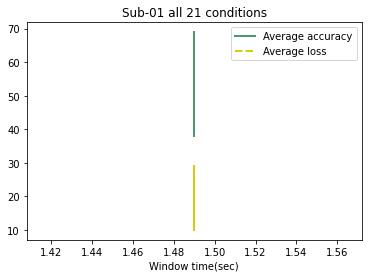

In [23]:
# multiple line plots

plt.plot( 'time_window', 'average_accuracy', data=df, marker='', 
         color='#4a996f', linewidth=2, label='Average accuracy')
plt.plot( 'time_window', 'average_loss', data=df, marker='', color='#d1cd10', 
         linewidth=2, linestyle='dashed', label='Average loss')
plt.title('Sub-01 all 21 conditions')
plt.xlabel("Window time(sec)")

# show legend
plt.legend()

# show graph
plt.show()